In [ ]:
# Install TensorFlow and other dependencies (if not already installed)
!pip install tensorflow==2.10.0
!pip install numpy==1.23
!pip install matplotlib
!pip install seaborn

 # TensorFlow with Verify GPU Usage

In [6]:
# Check TensorFlow with GPU Support
import tensorflow as tf

print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list GPUs

# If it prints a number greater than 0, TensorFlow is using the GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    print("TensorFlow GPU is available")
else:
    print("TensorFlow GPU is not available")

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
TensorFlow GPU is available


In [7]:
import tensorflow as tf
# Create a tensor and perform an operation to ensure GPU usage
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.matmul(a, a)

print("Computation completed on GPU.")

Computation completed on GPU.


#  Import Required Libraries

In [8]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import seaborn as sns

#  Set Data Source Paths

In [9]:

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Set dataset directory path
# dataset_path = '/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/dataset/augmented_updated'

# Define dataset paths
dataset_path = r'C:\xampp\htdocs\SLIIT\ent-disease-detection-dl-models\cholesteatoma_detection_and_classification\cholesteatoma_identifier\dataset\train'

 # Data Preprocessing

In [10]:
# Enhanced Dataset Preprocessing with More Augmentations
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


 # Load Pre-trained InceptionV3 Model

In [11]:
# Load InceptionV3 Model with ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add Custom Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)          # Dropout to reduce overfitting
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)          # Additional Dropout for regularization
predictions = Dense(4, activation='softmax')(x)

# Create & Compile the Model

In [12]:
# Create Model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze Base Model Layers for Initial Training
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model with a Warm-Up Learning Rate
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Start with a high learning rate for warm-up
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

 # Callbacks for Training & Train the Model

In [13]:
# Callbacks for Training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Fewer epochs for warm-up
    callbacks=callbacks
)

Epoch 1/25
50/50 [==============================] - 77s 952ms/step - loss: 18.1786 - accuracy: 0.5238 - val_loss: 15.2673 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 2/25
50/50 [==============================] - 39s 789ms/step - loss: 12.0922 - accuracy: 0.6125 - val_loss: 10.4275 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/25
50/50 [==============================] - 37s 745ms/step - loss: 8.4571 - accuracy: 0.6450 - val_loss: 7.2872 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 4/25
50/50 [==============================] - 36s 719ms/step - loss: 6.1680 - accuracy: 0.6800 - val_loss: 6.6063 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 5/25
50/50 [==============================] - 37s 733ms/step - loss: 4.6614 - accuracy: 0.6850 - val_loss: 4.4041 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 6/25
50/50 [==============================] - 37s 738ms/step - loss: 3.6414 - accuracy: 0.7106 - val_loss: 3.4349 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 7/25
50/50 [==============================] - 38s 759m

 # Fine-Tune the Model

In [14]:
# Gradually Unfreeze Layers for Fine-Tuning
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Fine-Tuned Model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
50/50 [==============================] - 45s 762ms/step - loss: 1.0809 - accuracy: 0.7287 - val_loss: 1.1131 - val_accuracy: 0.7575 - lr: 1.0000e-05
Epoch 2/25
50/50 [==============================] - 37s 748ms/step - loss: 0.9856 - accuracy: 0.7638 - val_loss: 1.0694 - val_accuracy: 0.7275 - lr: 1.0000e-05
Epoch 3/25
50/50 [==============================] - 37s 733ms/step - loss: 0.9163 - accuracy: 0.7912 - val_loss: 1.0714 - val_accuracy: 0.7100 - lr: 1.0000e-05
Epoch 4/25
50/50 [==============================] - 37s 740ms/step - loss: 0.8629 - accuracy: 0.8100 - val_loss: 1.0573 - val_accuracy: 0.7250 - lr: 1.0000e-05
Epoch 5/25
50/50 [==============================] - 37s 731ms/step - loss: 0.8198 - accuracy: 0.8250 - val_loss: 1.0669 - val_accuracy: 0.7050 - lr: 1.0000e-05
Epoch 6/25
50/50 [==============================] - 37s 731ms/step - loss: 0.7667 - accuracy: 0.8550 - val_loss: 0.9699 - val_accuracy: 0.7750 - lr: 1.0000e-05
Epoch 7/25
50/50 [======================

# Save the Model

In [15]:
# Save the trained model
model.save('InceptionV3_cholesteatoma_identifier_pp2.h5')
print("Model saved as InceptionV3_cholesteatoma_identifier_pp2.h5")

Model saved as InceptionV3_cholesteatoma_identifier_pp2.h5


 # Merge Training Histories

In [16]:
# Combine Histories for Visualization
# history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
# history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
# history.history['loss'].extend(fine_tune_history.history['loss'])
# history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

def merge_histories(history, fine_tune_history):
    for key in history.history.keys():
        history.history[key].extend(fine_tune_history.history[key])
    return history

history = merge_histories(history, fine_tune_history)

 # Plot Training Accuracy and Loss

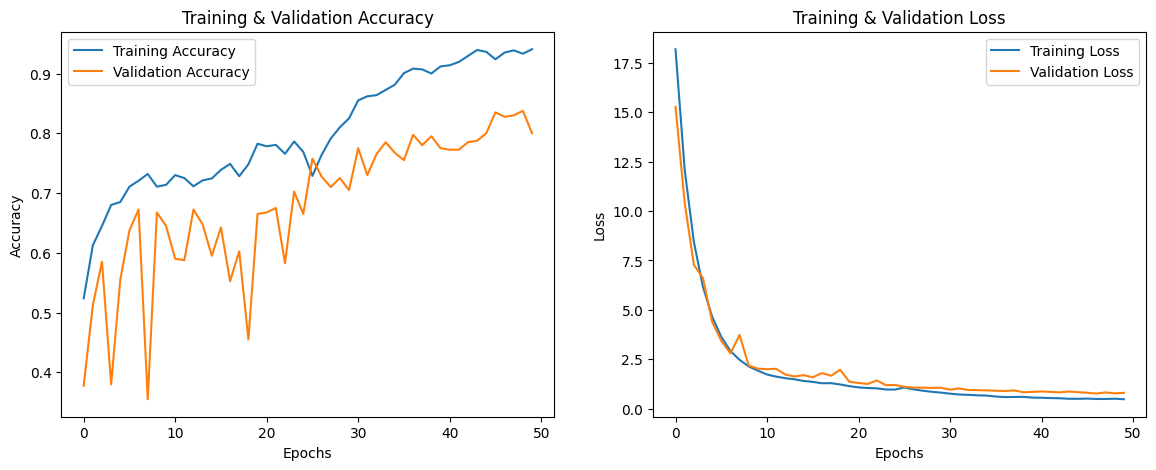

In [17]:
# Plot Training Accuracy and Loss
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Plot Loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.show()

plot_training_history(history)

 # Batch Metrics Plot

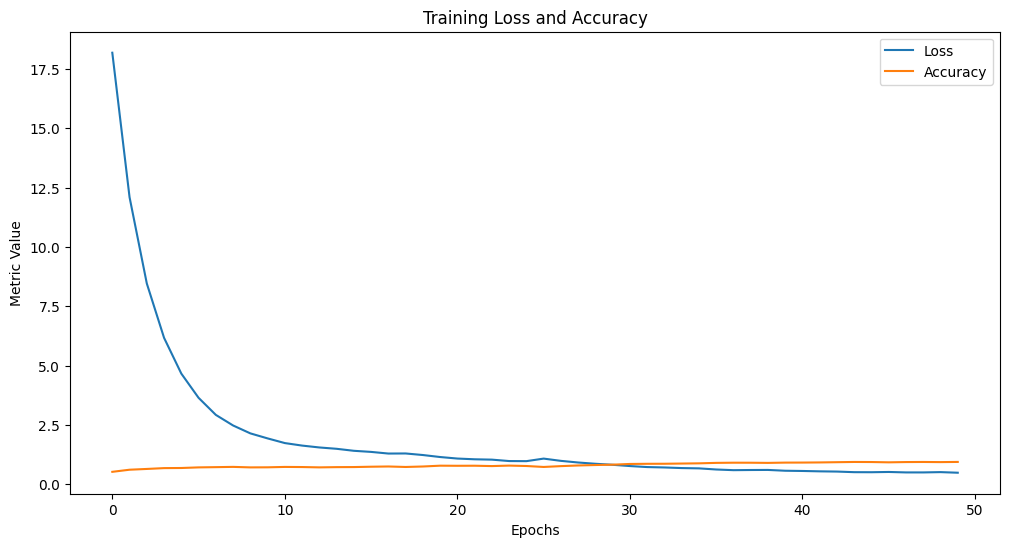

In [ ]:
# Batch Metrics Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

 # Confusion Matrix and Classification Report

13/13 [==============================] - 9s 555ms/step

Classification Report:

              precision    recall  f1-score   support

      Normal       0.20      0.22      0.21       100
     Stage 1       0.23      0.24      0.24       100
     Stage 2       0.29      0.25      0.27       100
     Stage 3       0.25      0.25      0.25       100

    accuracy                           0.24       400
   macro avg       0.24      0.24      0.24       400
weighted avg       0.24      0.24      0.24       400



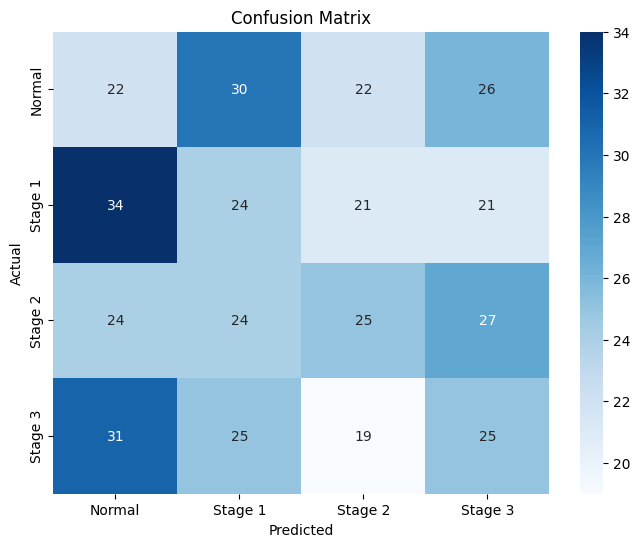

In [21]:
# Confusion Matrix and Classification Report
def evaluate_model(model, validation_generator):
    y_true = validation_generator.classes
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    class_labels = list(validation_generator.class_indices.keys())
    
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(model, validation_generator)

 # Load and Test the Model

In [22]:
# Test on new images
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and Test the Model
loaded_model = tf.keras.models.load_model('InceptionV3_cholesteatoma_identifier_pp2.h5')

def predict_image(img_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = loaded_model.predict(img_array)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[np.argmax(prediction)]

# Example Prediction
test_image_path = r'C:\xampp\htdocs\SLIIT\ent-disease-detection-dl-models\cholesteatoma_detection_and_classification\cholesteatoma_identifier\dataset\test\stage1-1.jpg' 
 # TODO: Update image/path
print(f"Predicted Class: {predict_image(test_image_path)}")

1/1 [==============================] - 2s 2s/step
Predicted Class: Normal


1/1 [==============================] - 1s 1s/step


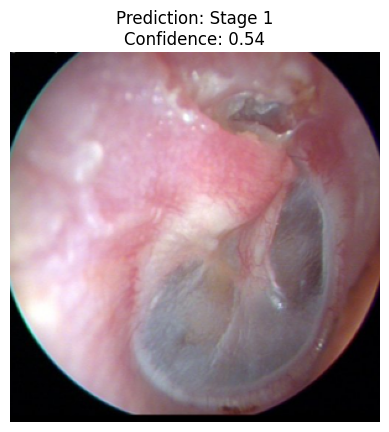

Class: Stage 1
Confidence Score: 0.5401859


In [25]:
import numpy as np
from keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Suppress scientific notation in numpy print
np.set_printoptions(suppress=True)

# Load the pre-trained model
model = load_model("InceptionV3_cholesteatoma_identifier_pp2.h5", compile=False)

# Class labels
class_names = ["Normal", "Stage 1", "Stage 2", "Stage 3"]

# Path to the image to be tested
image_path = r'C:\xampp\htdocs\SLIIT\ent-disease-detection-dl-models\cholesteatoma_detection_and_classification\cholesteatoma_identifier\dataset\test\stage1-1.jpg' 

# Load and preprocess the image
def preprocess_image(image_path, target_size=(299, 299)):
    # Open the image and ensure it's in RGB mode
    image = Image.open(image_path).convert("RGB")

    # Resize the image to the target size
    image = ImageOps.fit(image, target_size, Image.Resampling.LANCZOS)

    # Convert image to numpy array and normalize
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Expand dimensions to match model input
    return np.expand_dims(normalized_image_array, axis=0), image

# Preprocess the image and get the displayable version
data, display_image = preprocess_image(image_path)

# Perform the prediction
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Display the image with the prediction
plt.imshow(display_image)
plt.axis('off')
plt.title(f"Prediction: {class_name}\nConfidence: {confidence_score:.2f}")
plt.show()

# Print detailed prediction results
print("Class:", class_name)
print("Confidence Score:", confidence_score)